Sample size = 3.052e-03 mm
Reciprocal Window = 3.277e+02 mm-1
Reciprocal Sampling = 5.000e-03 mm-1
Real diffuser size = 3.052e-03 mm
RMS phase value = 9.070e-01 lambda


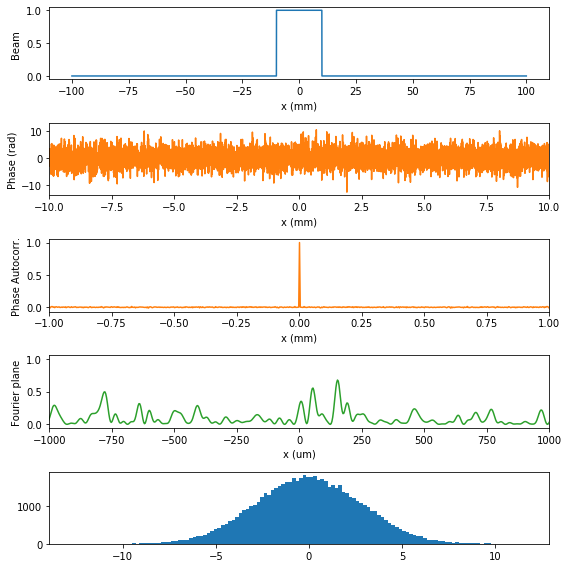

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat May 23 19:16:09 2020

@author: aline
"""
import numpy as np
from numpy import fft
import math as m
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline


##############################################################################
#
#                  USEFUL FUNCTIONS  
#
##############################################################################

def FFT(_f):
    return fft.fftshift(fft.fft(fft.ifftshift(_f)))

def iFFT(_f):
    return fft.fftshift(fft.ifft(fft.ifftshift(_f)))

def nextpow2(_x):
    res = m.ceil(m.log2(x))
    return int(res)

def gaussian (_x, _s):
    return np.exp(-_x**2/(2*_s))

def flattop (_x, _r):
    return np.abs(_x)<_r
    
def autocorr (_x):
    return np.real(FFT(np.abs(FFT(_x))**2))


##############################################################################
#
#                   SPECKLE CORE 
#
##############################################################################
    
################################
#
#       INPUT PARAMS
#  JUST PLAY WITH THOSE 
# IF YOU DON'T KNOW WHAT 
#     YOU ARE DOING    
#
################################
    
wlength = 0.633e-3 # In mm   
f = 1e3 # Focal length in mm
n = 16
N = int(m.pow(2, n))# Size of array

FLAG_GAUSSIAN = False
beamsize = 10 # Radius
beamSpace = 100 # Half window in real space before diffuser, in mm

diffSize = 1e-3 # Diffuser size in mm
stDev =  .91*m.pi # Standard deviation of gaussian distribution of diffusers


################################
#
#       CONVERSIONS 
#
################################
#stDev = HWHM*(m.sqrt(2*m.log(2)))

sampleSize = 2*beamSpace/N # In mm
print ('Sample size = %.3e mm'%sampleSize)

reciprocalWindow = 1/sampleSize # In mm-1
print ('Reciprocal Window = %.3e mm-1'%reciprocalWindow)
reciprocalSampling = reciprocalWindow/N
print ('Reciprocal Sampling = %.3e mm-1'%reciprocalSampling)
x2 = 1e3*np.linspace(-f*wlength*reciprocalWindow/2, 
                      f*wlength*reciprocalWindow/2, N) # In microns

diffPxNum = np.ceil(diffSize/sampleSize)
print ('Real diffuser size = %.3e mm'%(diffPxNum*sampleSize))

################################
#
#    GAUSSIAN OR FLAT TOP  
#
################################

if FLAG_GAUSSIAN :
    x = np.linspace(-beamSpace, beamSpace, N)
    beam = np.array([gaussian(i, beamsize) for i in x]) 
    # gaussian beam with plane wavefront

else :
    x = np.linspace(-beamSpace, beamSpace, N)
    beam = np.array(flattop(x, beamsize))

################################
#
#  GENERATING PHASE SURFACE  
#
################################

# Random phase surface: spline allows to introduce diffuser corr length

xp = np.linspace(-beamSpace, beamSpace, int(N/diffPxNum))
phase = np.random.normal(0, stDev, int(N/diffPxNum))

phaseSpline = InterpolatedUnivariateSpline(xp, phase)
phase = phaseSpline(x)

phaseAutocorr = autocorr (phase)
phaseAutocorr = phaseAutocorr/np.max(phaseAutocorr)

phaseRMS = np.std(phase)/np.pi
print ('RMS phase value = %.3e lambda'%phaseRMS)

################################
#
#  CALCULATING FOURIER PLANE  
#
################################

beamWithPhase = np.array([beam[b]*np.exp(-1j*phase[b]) for b in range(0, N)])
farField = FFT(beamWithPhase)*np.conj(FFT(beamWithPhase))
farField = np.real(farField/np.max(farField))

##############################################################################
#
#                   PLOTS 
#
##############################################################################

fig, axs = plt.subplots(5)
fig.set_figheight(8)
fig.set_figwidth(8)


axs[0].plot(x, beam)
axs[1].plot(x, phase, 'tab:orange')
axs[1].set_xlim(-10, 10)
axs[2].plot(x, phaseAutocorr, 'tab:orange')
axs[2].set_xlim(-1, 1)
axs[3].plot(x2, farField, 'tab:green')
axs[3].set_xlim(-1000, 1000)
axs[4].hist(phase, bins = 'auto')


xlabels = ['x (mm)', 'x (mm)', 'x (mm)', 'x (um)']
ylabels = ['Beam ', 'Phase (rad)', 'Phase Autocorr.', 'Fourier plane']

for i in range(0, len(axs.flat)-1):
    axs.flat[i].set(xlabel=xlabels[i], ylabel=ylabels[i])

plt.tight_layout()
plt.show()

